[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/movielens_skorch.ipynb)

# To do:
  - create object classes for models

In [1]:
# !pip install tensorflow-gpu==2.0.0-beta1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, datetime
import warnings

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.math import add

from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-100k/'  # if the files are local
df = pd.read_csv(path+'ratings.csv')

In [3]:
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
n_users = df.userId.nunique()
n_items = df.movieId.nunique()
print('Number of users:', n_users)
print('Number of items:', n_items)

Number of users: 943
Number of items: 1682


## Add baseline predictors

In [6]:
train, test, _, _ = train_test_split(df, df.rating, test_size=.1, random_state=42)

In [7]:
min_rating = df.rating.min()
max_rating = df.rating.max()
mean_rating = train.rating.mean()
print("Min item rating:", min_rating)
print("Max item rating:", max_rating)
print("Mean item rating:", mean_rating)

Min item rating: 1
Max item rating: 5
Mean item rating: 3.5308444444444445


In [8]:
user_averages = train.groupby('userId') \
    .agg({'rating':'mean'}) \
    .rename({'rating': 'user_avg'}, axis=1) \
    .reset_index()

user_averages.head()

,userId,user_avg
0,0,3.542857
1,1,3.433735
2,2,3.285714
3,3,3.671233
4,4,3.388889


In [9]:
item_averages = train.groupby('movieId') \
    .agg({'rating':'mean'}) \
    .rename({'rating': 'item_avg'}, axis=1) \
    .reset_index()

item_averages.head()

,movieId,item_avg
0,0,3.980952
1,1,4.164122
2,2,2.111111
3,3,3.449275
4,4,3.652542


In [10]:
train = pd.merge(train, user_averages, how='left', on='userId')
train = pd.merge(train, item_averages, how='left', on='movieId')
test = pd.merge(test, user_averages, how='left', on='userId')
test = pd.merge(test, item_averages, how='left', on='movieId')

In [11]:
# users and items in test that aren't in train will get the average rating of all users
test.user_avg = test.user_avg.fillna(mean_rating)
test.item_avg = test.item_avg.fillna(mean_rating)

In [12]:
train['bias'] = (train['user_avg'] + train['item_avg'])/2 - mean_rating
test['bias'] = (test['user_avg'] + test['item_avg'])/2 - mean_rating

In [13]:
test.head()

,userId,movieId,rating,user_avg,item_avg,bias
0,873,377,4,3.777778,3.588235,0.152162
1,808,601,3,3.738372,3.697674,0.187179
2,90,354,4,3.637119,3.562963,0.069197
3,409,570,2,3.844639,2.755102,-0.230974
4,496,356,2,3.351485,3.920398,0.105097


## Ratings model

### Grid search
**To do**:
  - tune dropout rates and optimiser
  - measure impact on accuracy of genre model

In [14]:
def compile_model(n_factors, n_hidden_1, n_hidden_2, dropout_1, dropout_2, opt):
    
    # TODO: n_items, n_users and mean_rating are all hard coded at the moment
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_factors)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_factors)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # if there is a hidden layer
    if n_hidden_1:
        # concatenate user and item vectors
        conc = Concatenate()([item_vec, user_vec])
        # hidden layer 1
        hidden_1 = Dense(n_hidden_1, activation='relu')(conc)
        drop_1 = Dropout(dropout_1)(hidden_1)
        
        # if there is a second hidden layer
        if n_hidden_2:
            # hidden layer 2
            hidden_2 = Dense(n_hidden_2, activation='relu')(drop_1)
            drop_2 = Dropout(dropout_2)(hidden_2)
            
            # unscaled output
            out = Dense(1)(drop_2)
        else:
            out = Dense(1)(drop_1)
        
    # if there are no hidden layers
    else:
        out = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
    
    rating = add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(opt, 'mean_squared_error')
    
    return model

In [15]:
# hyper parameters
HP_N_FACTORS = [5, 10, 25, 50]
HP_N_HIDDEN_1 = [0, 8, 16, 32, 64]
HP_N_HIDDEN_2 = [0, 16, 32]
HP_DROPOUT_1 = [.1, .15, .2, .25]
HP_DROPOUT_2 = [.1, .15, .2, .25]
HP_OPTIMISER = ['adam', 'sgd']

Fitting model for 5 latent factors, 0 units in h1, 0 units in h2



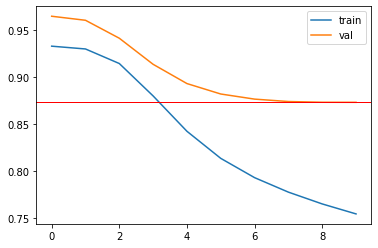


Fitting model for 5 latent factors, 0 units in h1, 16 units in h2



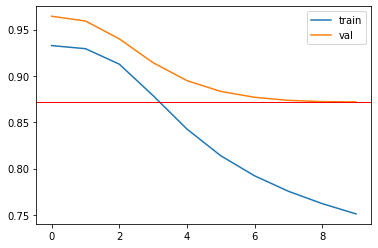


Fitting model for 5 latent factors, 0 units in h1, 32 units in h2



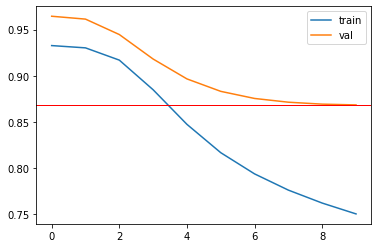


Fitting model for 5 latent factors, 8 units in h1, 0 units in h2



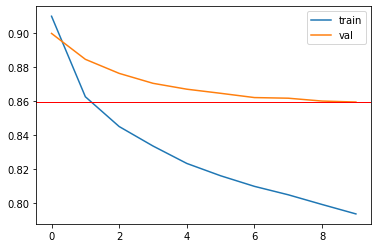


Fitting model for 5 latent factors, 8 units in h1, 16 units in h2



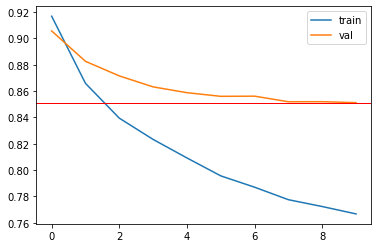


Fitting model for 5 latent factors, 8 units in h1, 32 units in h2



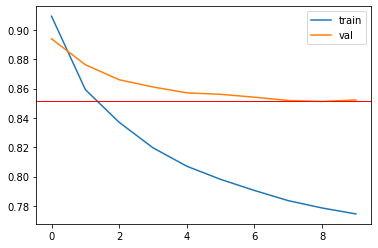


Fitting model for 5 latent factors, 16 units in h1, 0 units in h2



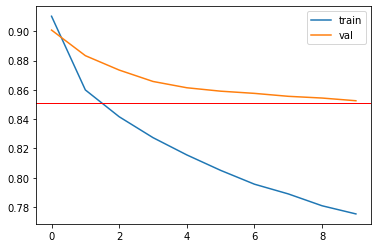


Fitting model for 5 latent factors, 16 units in h1, 16 units in h2



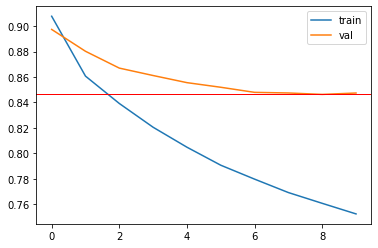


Fitting model for 5 latent factors, 16 units in h1, 32 units in h2



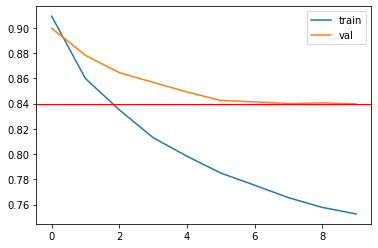


Fitting model for 5 latent factors, 32 units in h1, 0 units in h2



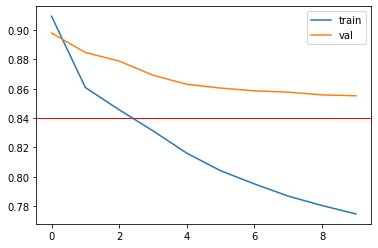


Fitting model for 5 latent factors, 32 units in h1, 16 units in h2



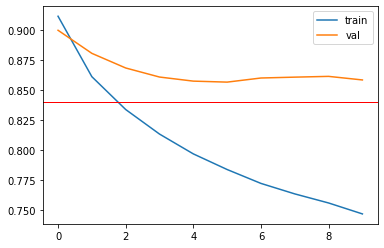


Fitting model for 5 latent factors, 32 units in h1, 32 units in h2



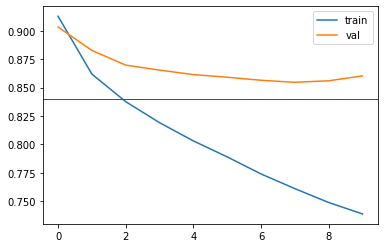


Fitting model for 5 latent factors, 64 units in h1, 0 units in h2



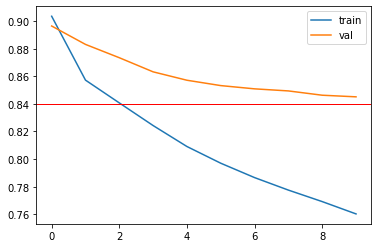


Fitting model for 5 latent factors, 64 units in h1, 16 units in h2



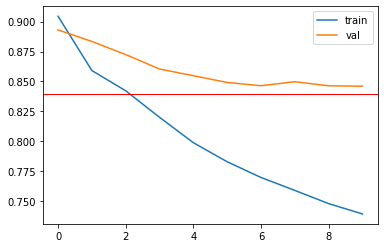


Fitting model for 5 latent factors, 64 units in h1, 32 units in h2



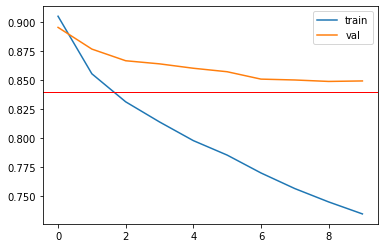


Fitting model for 10 latent factors, 0 units in h1, 0 units in h2



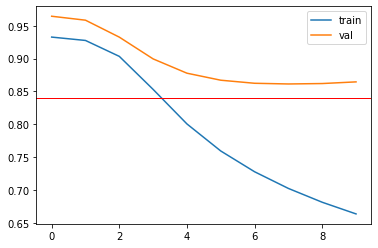


Fitting model for 10 latent factors, 0 units in h1, 16 units in h2



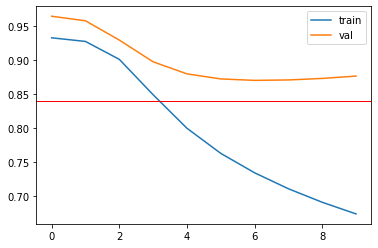


Fitting model for 10 latent factors, 0 units in h1, 32 units in h2



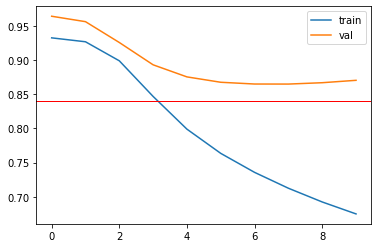


Fitting model for 10 latent factors, 8 units in h1, 0 units in h2



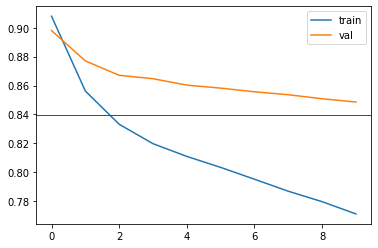


Fitting model for 10 latent factors, 8 units in h1, 16 units in h2



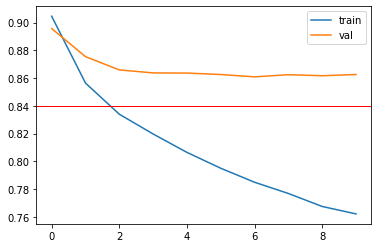


Fitting model for 10 latent factors, 8 units in h1, 32 units in h2



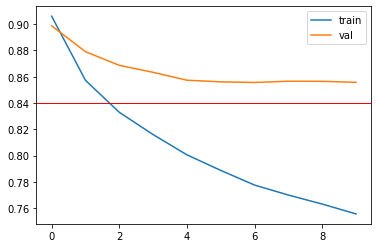


Fitting model for 10 latent factors, 16 units in h1, 0 units in h2



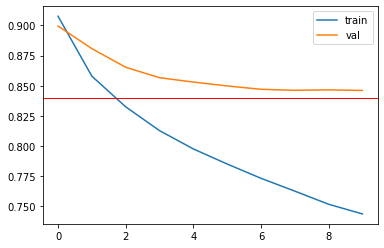


Fitting model for 10 latent factors, 16 units in h1, 16 units in h2



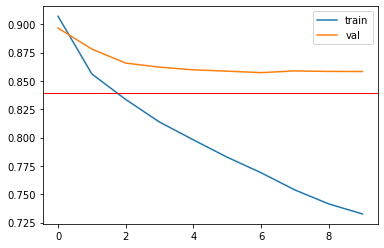


Fitting model for 10 latent factors, 16 units in h1, 32 units in h2



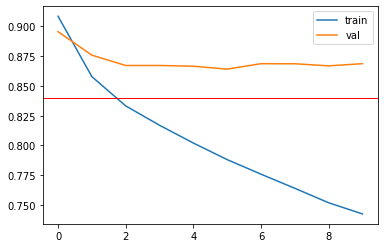


Fitting model for 10 latent factors, 32 units in h1, 0 units in h2



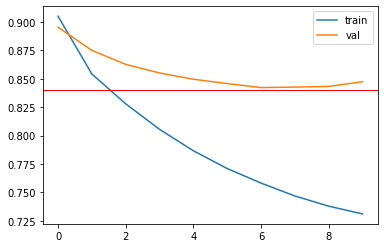


Fitting model for 10 latent factors, 32 units in h1, 16 units in h2



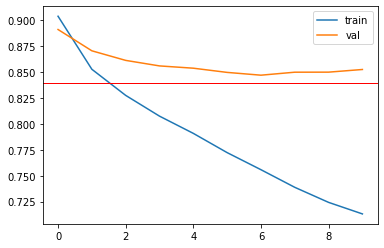


Fitting model for 10 latent factors, 32 units in h1, 32 units in h2



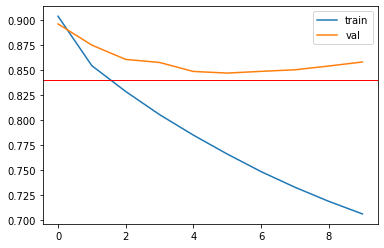


Fitting model for 10 latent factors, 64 units in h1, 0 units in h2



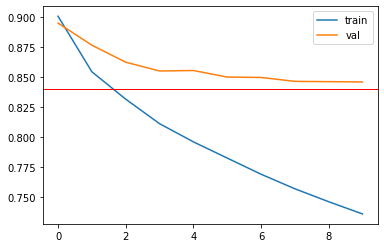


Fitting model for 10 latent factors, 64 units in h1, 16 units in h2



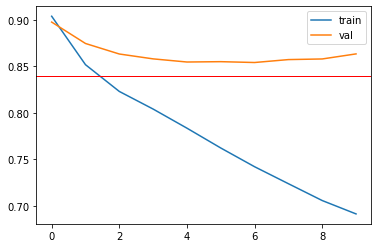


Fitting model for 10 latent factors, 64 units in h1, 32 units in h2



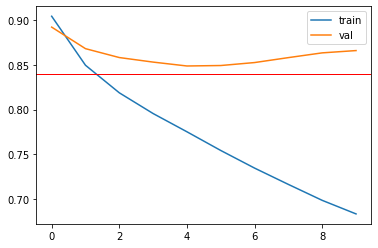


Fitting model for 25 latent factors, 0 units in h1, 0 units in h2



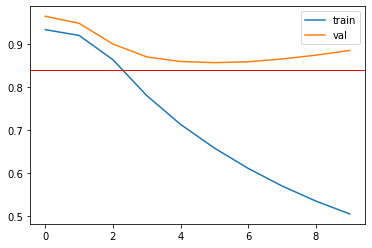


Fitting model for 25 latent factors, 0 units in h1, 16 units in h2



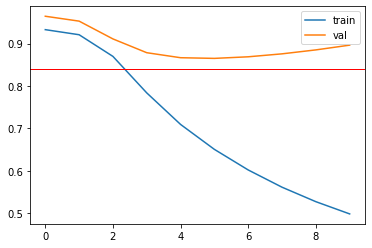


Fitting model for 25 latent factors, 0 units in h1, 32 units in h2



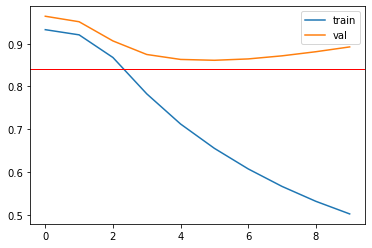


Fitting model for 25 latent factors, 8 units in h1, 0 units in h2



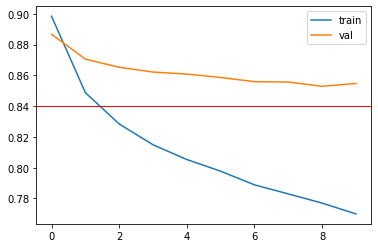


Fitting model for 25 latent factors, 8 units in h1, 16 units in h2



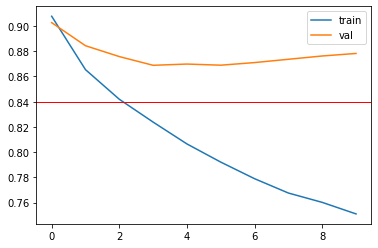


Fitting model for 25 latent factors, 8 units in h1, 32 units in h2



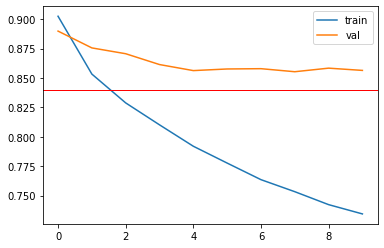


Fitting model for 25 latent factors, 16 units in h1, 0 units in h2



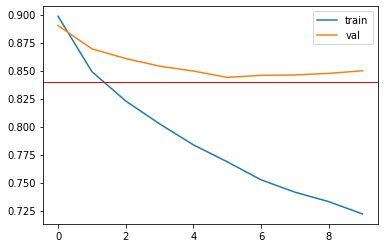


Fitting model for 25 latent factors, 16 units in h1, 16 units in h2



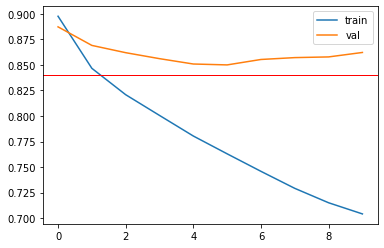


Fitting model for 25 latent factors, 16 units in h1, 32 units in h2



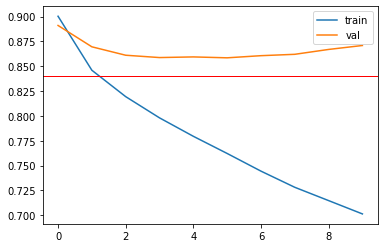


Fitting model for 25 latent factors, 32 units in h1, 0 units in h2



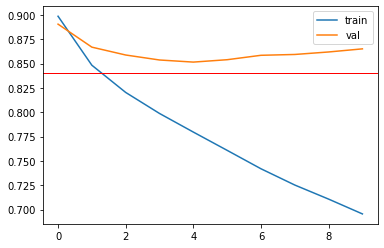


Fitting model for 25 latent factors, 32 units in h1, 16 units in h2



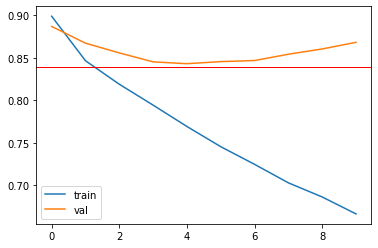


Fitting model for 25 latent factors, 32 units in h1, 32 units in h2



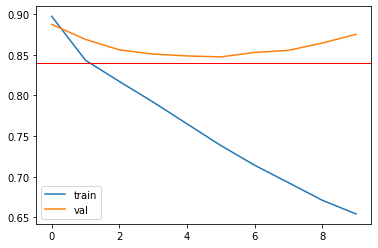


Fitting model for 25 latent factors, 64 units in h1, 0 units in h2



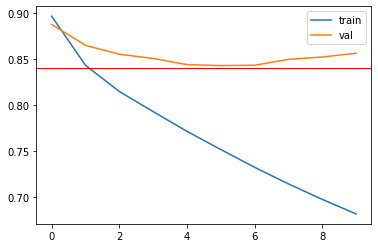


Fitting model for 25 latent factors, 64 units in h1, 16 units in h2



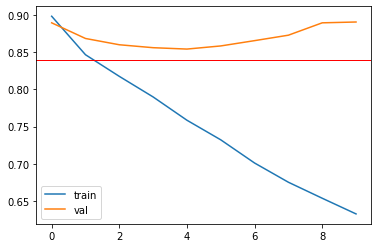


Fitting model for 25 latent factors, 64 units in h1, 32 units in h2



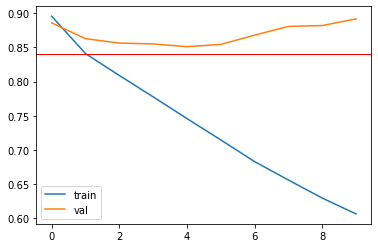


Fitting model for 50 latent factors, 0 units in h1, 0 units in h2



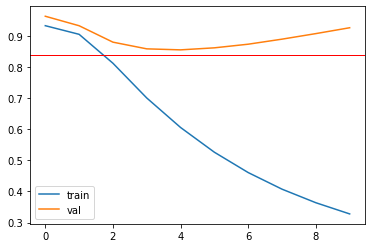


Fitting model for 50 latent factors, 0 units in h1, 16 units in h2



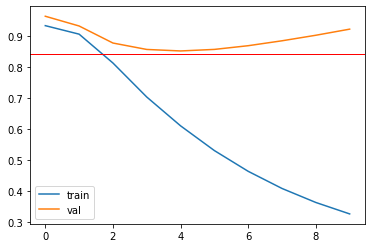


Fitting model for 50 latent factors, 0 units in h1, 32 units in h2



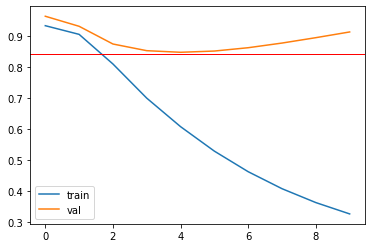


Fitting model for 50 latent factors, 8 units in h1, 0 units in h2



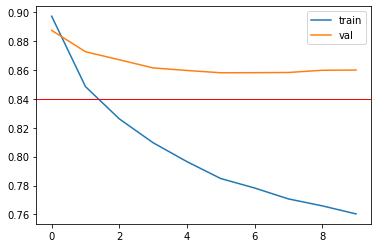


Fitting model for 50 latent factors, 8 units in h1, 16 units in h2



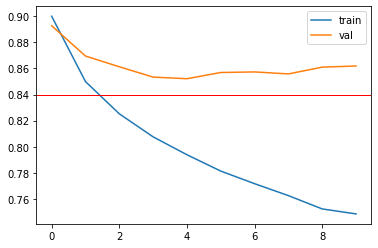


Fitting model for 50 latent factors, 8 units in h1, 32 units in h2



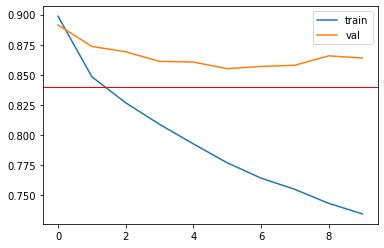


Fitting model for 50 latent factors, 16 units in h1, 0 units in h2



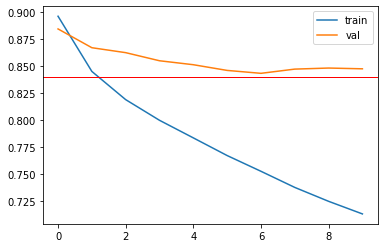


Fitting model for 50 latent factors, 16 units in h1, 16 units in h2



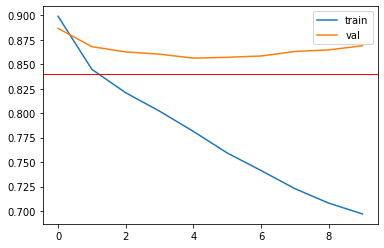


Fitting model for 50 latent factors, 16 units in h1, 32 units in h2



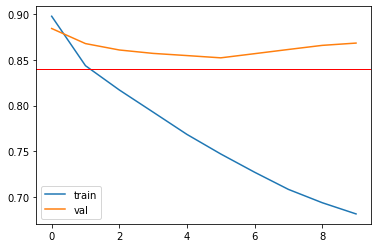


Fitting model for 50 latent factors, 32 units in h1, 0 units in h2



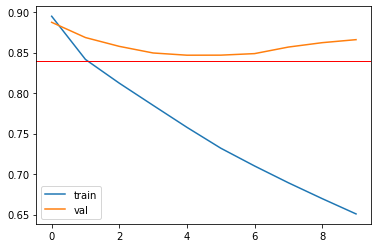


Fitting model for 50 latent factors, 32 units in h1, 16 units in h2



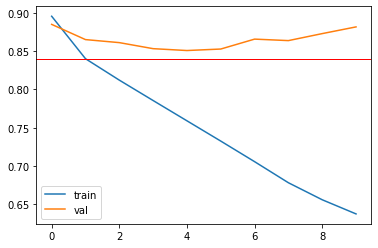


Fitting model for 50 latent factors, 32 units in h1, 32 units in h2



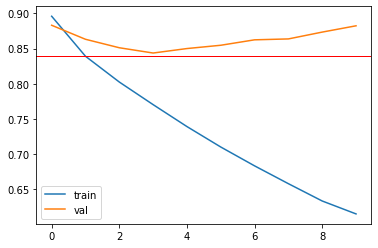


Fitting model for 50 latent factors, 64 units in h1, 0 units in h2



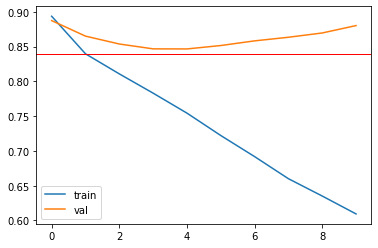


Fitting model for 50 latent factors, 64 units in h1, 16 units in h2



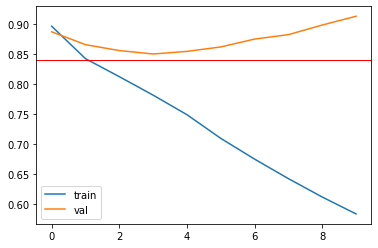


Fitting model for 50 latent factors, 64 units in h1, 32 units in h2



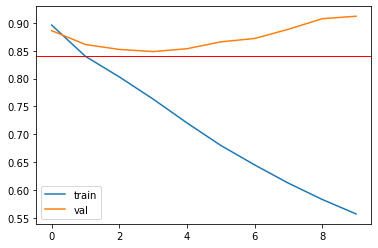

,n_factors,hidden_1,hidden_2,val_rmse
8,5,16,32,0.916403
24,10,32,0,0.917729
42,25,64,0,0.917922
40,25,32,16,0.918249
56,50,32,32,0.918481
51,50,16,0,0.918498
36,25,16,0,0.918639
12,5,64,0,0.919292
27,10,64,0,0.919713
13,5,64,16,0.919810


In [16]:
# dataframe to store results of grid search
grid_results = []
best_loss = 1

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN_1 in HP_N_HIDDEN_1:
        for N_HIDDEN_2 in HP_N_HIDDEN_2:
            
            print(f'Fitting model for {N_FACTORS} latent factors, {N_HIDDEN_1} units in h1, {N_HIDDEN_2} units in h2\n')
            
            model = compile_model(
                n_factors = N_FACTORS,
                n_hidden_1 = N_HIDDEN_1,
                n_hidden_2 = N_HIDDEN_2,
                dropout_1 = .1,
                dropout_2 = .1,
                opt = 'adam'
            )
            
            result = model.fit(x=[train.userId.values, train.movieId.values, train.bias.values],
                               y=train.rating.values, 
                               batch_size=256,
                               epochs=7,
                               verbose=0,
                               validation_data=([test.userId.values, test.movieId.values, test.bias.values], test.rating.values))
            
            val_loss = min(result.history['val_loss'])
            if val_loss < best_loss:
                best_loss = val_loss
            
            plt.plot(result.history['loss'], label='train')
            plt.plot(result.history['val_loss'], label='val')
            plt.axhline(y=best_loss, color='r', lw=1, ls='-')
            plt.legend()
            plt.show()
            print()
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'hidden_1':N_HIDDEN_1,
                                 'hidden_2':N_HIDDEN_2,
                                 'val_rmse':np.sqrt(val_loss)})
#             break
#         break
#     break
grid_results = pd.DataFrame(data=grid_results)
grid_results.sort_values('val_rmse')